In [1]:
# Library Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

![](https://www.nytco.com/wp-content/themes/nytco/images/nytco/NYT-wordmark.png)

# NY Comments

In [2]:
comments = pd.read_csv('https://raw.githubusercontent.com/mkleinbort/resource-datasets/master/ny_times_comments/CommentsApril2017_simple.csv')

In [3]:
comments.head()

,commentBody,recommendations,replyCount,editorsSelection
0,We need a shot down of the self-serving ONGRES...,1.0,0.0,False
1,Mining for coal and oil have caused untold dis...,3.0,0.0,False
2,Congratulations NYT for excellent work for you...,1.0,0.0,False
3,"If you want to beat Facebook, just provide vid...",2.0,0.0,False
4,will trump turn out to be the American Right's...,0.0,0.0,False


# EDA

In [4]:
# Look at the number of rows and columns
comments.shape

(9000, 4)

In [5]:
# Confirming dtypes
comments.dtypes

commentBody          object
recommendations     float64
replyCount          float64
editorsSelection       bool
dtype: object

In [6]:
# Number of unique values in each column
comments.nunique()

commentBody         9000
recommendations      888
replyCount            69
editorsSelection       2
dtype: int64

In [7]:
# How many comments were selected by the editors?
comments['editorsSelection'].value_counts()

True     4500
False    4500
Name: editorsSelection, dtype: int64

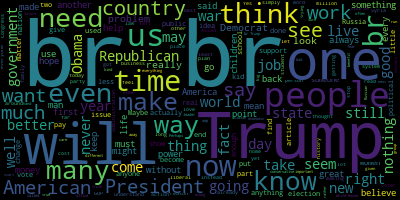

In [8]:
from wordcloud import WordCloud


# All comments
wc = WordCloud()
wc.generate_from_text(' '.join(comments['commentBody']))
wc.to_image()

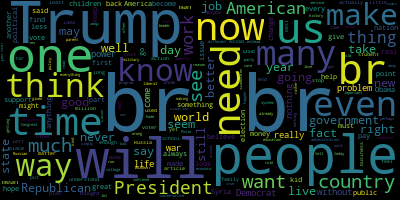

In [9]:
# Editor selected comments
wc = WordCloud()
wc.generate_from_text(' '.join(comments.query('editorsSelection == True')['commentBody']))
wc.to_image()

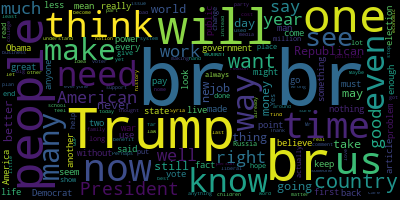

In [10]:
# Editor rejected comments
wc = WordCloud()
wc.generate_from_text(' '.join(comments.query('editorsSelection != True')['commentBody']))
wc.to_image()

# Preparing the data

Try to predict whether a comment will be selected by the editors using only the comment itself.

In [11]:
# Separating the features from the target
y = comments['editorsSelection']
features = comments[['commentBody']]

features.head()

,commentBody
0,We need a shot down of the self-serving ONGRES...
1,Mining for coal and oil have caused untold dis...
2,Congratulations NYT for excellent work for you...
3,"If you want to beat Facebook, just provide vid..."
4,will trump turn out to be the American Right's...


### Creating numeric features

In [12]:
# Let's create a column that tracks the wordcount of each comment.
features['commentLength'] = features['commentBody'].apply(lambda x: len(x.split(' ')))
features.head()

,commentBody,commentLength
0,We need a shot down of the self-serving ONGRES...,16
1,Mining for coal and oil have caused untold dis...,50
2,Congratulations NYT for excellent work for you...,152
3,"If you want to beat Facebook, just provide vid...",16
4,will trump turn out to be the American Right's...,28


In [13]:
# Let's create a column that tracks the # of ALLCAPS words.
def count_allcaps(text):
    total = 0
    for word in text.split(' '):
        if word.isupper():
            total += 1
    return total

features['countAllCaps'] = features['commentBody'].apply(count_allcaps)
features.head()

,commentBody,commentLength,countAllCaps
0,We need a shot down of the self-serving ONGRES...,16,1
1,Mining for coal and oil have caused untold dis...,50,1
2,Congratulations NYT for excellent work for you...,152,4
3,"If you want to beat Facebook, just provide vid...",16,0
4,will trump turn out to be the American Right's...,28,0


In [14]:
# Let's create a column that tracks if the first word is capitalized.
features['startsWithCap'] = features['commentBody'].apply(lambda x : x[0].isupper())
features.head()

,commentBody,commentLength,countAllCaps,startsWithCap
0,We need a shot down of the self-serving ONGRES...,16,1,True
1,Mining for coal and oil have caused untold dis...,50,1,True
2,Congratulations NYT for excellent work for you...,152,4,True
3,"If you want to beat Facebook, just provide vid...",16,0,True
4,will trump turn out to be the American Right's...,28,0,False


In [15]:
# Let's create a column that tracks if the # of words with the first letter capitalized.
def count_capitalized(text):
    total = 0
    for word in text.split(' '):
        if word.istitle():
            total += 1
    return total

features['countStartsWithCap'] = features['commentBody'].apply(count_capitalized)
features.head()

,commentBody,commentLength,countAllCaps,startsWithCap,countStartsWithCap
0,We need a shot down of the self-serving ONGRES...,16,1,True,1
1,Mining for coal and oil have caused untold dis...,50,1,True,3
2,Congratulations NYT for excellent work for you...,152,4,True,17
3,"If you want to beat Facebook, just provide vid...",16,0,True,2
4,will trump turn out to be the American Right's...,28,0,False,6


In [16]:
X = features.drop(['commentBody'], axis=1)

In [17]:
X.shape

(9000, 4)

In [18]:
X.head()

,commentLength,countAllCaps,startsWithCap,countStartsWithCap
0,16,1,True,1
1,50,1,True,3
2,152,4,True,17
3,16,0,True,2
4,28,0,False,6


# Training Models

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

### Training a LogisticRegression

In [20]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.6444444444444445

### Training a LogisticRegression with a different C value.

A smaller C value means the model will overfit the data less.

In [21]:
lr = LogisticRegression(C=0.001)

lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.6583333333333333

Best model so far: Logistic Regression with C=0.001

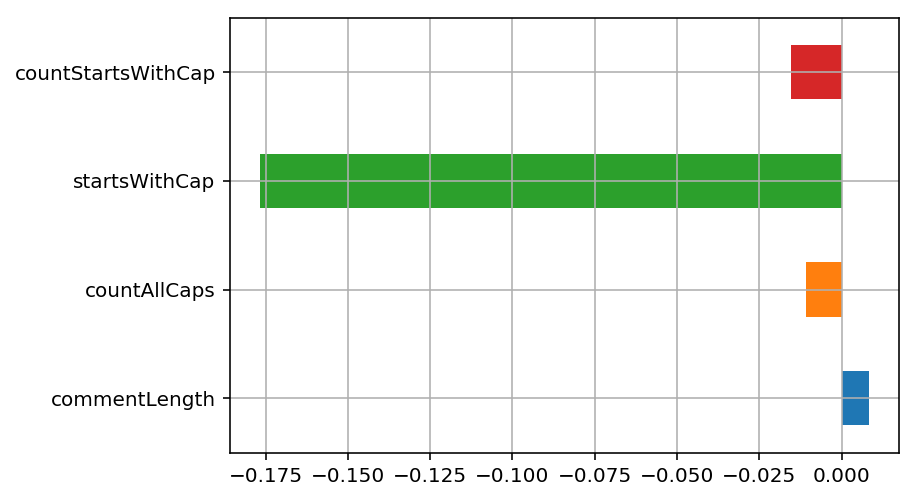

In [24]:
# Looking at the features and their effect 

feature_coef_dict = {col:coef for col, coef in zip(X.columns, lr.coef_[0])}
feature_coef_series = pd.Series(feature_coef_dict)

feature_coef_series.plot(kind='barh', grid=True)

# Preparing the data (Again)

In [22]:
features.head()

,commentBody,commentLength,countAllCaps,startsWithCap,countStartsWithCap
0,We need a shot down of the self-serving ONGRES...,16,1,True,1
1,Mining for coal and oil have caused untold dis...,50,1,True,3
2,Congratulations NYT for excellent work for you...,152,4,True,17
3,"If you want to beat Facebook, just provide vid...",16,0,True,2
4,will trump turn out to be the American Right's...,28,0,False,6


In [23]:
X.head()

,commentLength,countAllCaps,startsWithCap,countStartsWithCap
0,16,1,True,1
1,50,1,True,3
2,152,4,True,17
3,16,0,True,2
4,28,0,False,6


# Sentiment analysis with Python

Disclaimer: This is a very crude method.

In [28]:
# !pip install textblob
from textblob.en.sentiments import PatternAnalyzer

pa = PatternAnalyzer()

In [29]:
# Example usage
pa.analyze('I LOVE puppies.')

Sentiment(polarity=0.5, subjectivity=0.6)

In [30]:
pa.analyze('This cake is great.')

Sentiment(polarity=0.8, subjectivity=0.75)

In [31]:
pa.analyze('The new law makes me angry.')

Sentiment(polarity=-0.18181818181818182, subjectivity=0.7272727272727273)

In [32]:
pa.analyze('I hate the ending of that movie.')

Sentiment(polarity=-0.8, subjectivity=0.9)

In [33]:
# How to select only the polarity score
pa.analyze('I hate the ending of that movie.').polarity

-0.8

# Applying this to the NY comments dataset


In [34]:
X.head()

,commentLength,countAllCaps,startsWithCap,countStartsWithCap
0,16,1,True,1
1,50,1,True,3
2,152,4,True,17
3,16,0,True,2
4,28,0,False,6


In [35]:
# This is a little slow
X['polarity'] = features['commentBody'].apply(lambda x: pa.analyze(x).polarity)
X.head()

,commentLength,countAllCaps,startsWithCap,countStartsWithCap,polarity
0,16,1,True,1,-0.155556
1,50,1,True,3,0.000000
2,152,4,True,17,0.243740
3,16,0,True,2,0.000000
4,28,0,False,6,0.128571


# Training Models (Again)

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [37]:
lr = LogisticRegression(C=0.001)

lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.6583333333333333

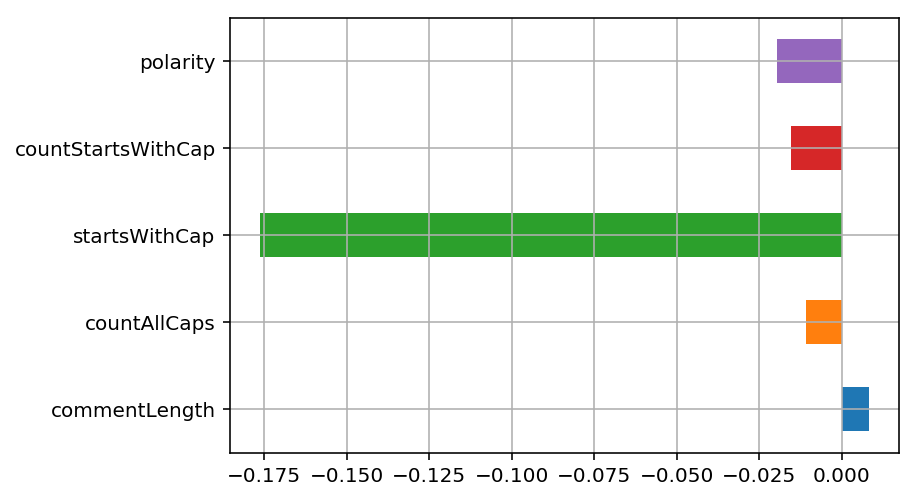

In [38]:
# Looking at the features and their effect 

feature_coef_dict = {col:coef for col, coef in zip(X.columns, lr.coef_[0])}
feature_coef_series = pd.Series(feature_coef_dict)

feature_coef_series.plot(kind='barh', grid=True)

# Part 4: Model Evaluation

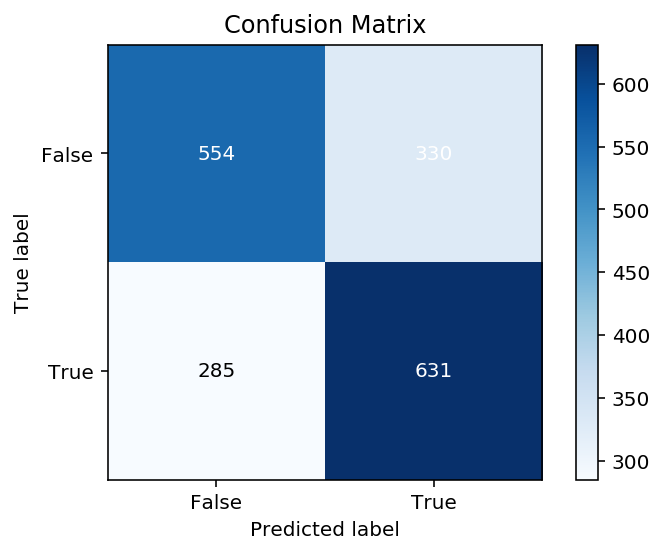

In [42]:
from scikitplot.metrics import plot_confusion_matrix

y_pred = lr.predict(X_test)

plot_confusion_matrix(y_test, y_pred)


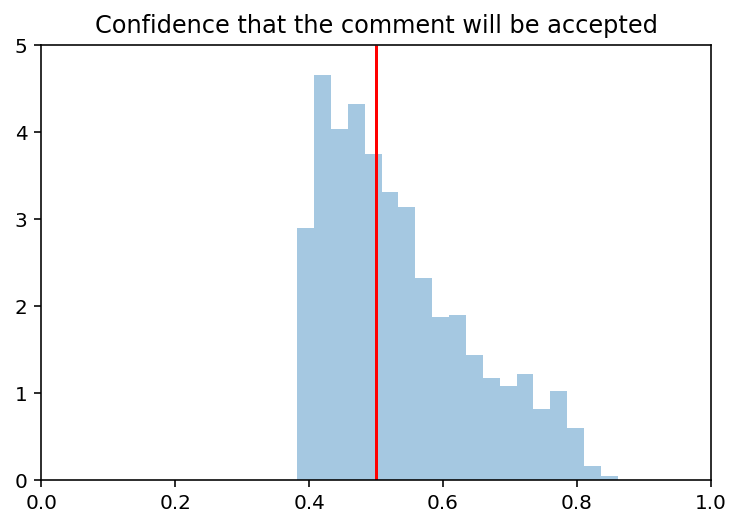

In [43]:
y_proba = lr.predict_proba(X_test)
y_pred = lr.predict(X_test)

sns.distplot(y_proba[:,1], norm_hist=True, kde=False)
plt.xlim([0,1])
plt.ylim([0,5])
plt.title('Confidence that the comment will be accepted')
plt.vlines(x=0.5, ymin=0, ymax=5, colors='r')
plt.show()

In [45]:
lr.classes_

array([False,  True])

In [46]:
from sklearn.metrics import accuracy_score

# Our model is not very good at detecting comments editors will adore.
accuracy_score(y_test[y_proba[:,1] > 0.8], y_pred[y_proba[:,1] > 0.8])

0.7058823529411765

In [47]:
# Our model much better at detecting comments editors will readily reject.
accuracy_score(y_test[y_proba[:,1] < 0.4], y_pred[y_proba[:,1] < 0.4])

0.8571428571428571

# Code Summary

In [48]:
# Library Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

from textblob.en.sentiments import PatternAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

comments = pd.read_csv('https://raw.githubusercontent.com/mkleinbort/resource-datasets/master/ny_times_comments/CommentsApril2017_simple.csv')

# Separating the features from the target
y = comments['editorsSelection']
features = comments[['commentBody']]

# Let's create a column that tracks the wordcount of each comment.
features['commentLength'] = features['commentBody'].apply(lambda x: len(x.split(' ')))

# Let's create a column that tracks the # of ALLCAPS words.
def count_allcaps(text):
    total = 0
    for word in text.split(' '):
        if word.isupper():
            total += 1
    return total

features['countAllCaps'] = features['commentBody'].apply(count_allcaps)


# Let's create a column that tracks if the first word is capitalized.
features['startsWithCap'] = features['commentBody'].apply(lambda x : x[0].isupper())

# Let's create a column that tracks if the # of words with the first letter capitalized.
def count_capitalized(text):
    total = 0
    for word in text.split(' '):
        if word.istitle():
            total += 1
    return total

features['countStartsWithCap'] = features['commentBody'].apply(count_capitalized)

# Let's get a crude estimate of the polarity of each comment.

pa = PatternAnalyzer()

features['polarity'] = features['commentBody'].apply(lambda x: pa.analyze(x).polarity)

X = features.drop(['commentBody'], axis=1)

# Performing a train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# Instanciating a model with hyperparameters of our choice
lr = LogisticRegression(C=0.001)

# Fitting the model on the training data
lr.fit(X_train, y_train)

# Scoring the model on our test data
lr.score(X_test, y_test)

0.6583333333333333

# Other things to try out

You could aim to leverage either a pre-trained spacy model, or use word tokenization.

In [50]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import spacy
nlp = spacy.load('en_core_web_md')